In [70]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

In [71]:
generator_model_path = "C:/Users/allan/PycharmProjects/Edge2Face/Models/Epoch15/Generator"
discriminator_model_path = "C:/Users/allan/PycharmProjects/Edge2Face/Models/Epoch15/Discriminator"

In [72]:
generator_model = tf.keras.models.load_model(generator_model_path)

In [73]:
def generate_images(starting_image, generator_input, prediction):    

    plt.figure(figsize=(15, 15))

    display_list = [starting_image, generator_input, prediction]
    title = [
        'Starting image', 
        'Generator input', 
        'Generator output'
    ]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        pass
    plt.show()
    pass

In [74]:
def plot_single_image(image_tensor):
    plt.imshow(image_tensor)
    plt.show()

In [75]:
def post_process_tensor(tensor):
    tensor = np.array(tensor)
    tensor = tensor*0.5+0.5

    #Convert to UInt8
    tensor = tensor*255
    tensor = tensor.astype(np.uint8)
    return tensor

In [76]:
def center_crop(img):
    #Get the 2 dimensions
    dim1 = img.shape[0]
    dim2 = img.shape[1]

    #Get the smaller dim
    smaller_dim = min(dim1, dim2)

    #Get the center for both dimensions
    dim1_center = dim1 // 2
    dim2_center = dim2 // 2

    #Crop from center for both dimensions
    dim1_start = dim1_center-smaller_dim//2
    dim1_end = dim1_center+smaller_dim//2

    dim2_start = dim2_center-smaller_dim//2
    dim2_end = dim2_center+smaller_dim//2

    img = img[dim1_start:dim1_end, dim2_start:dim2_end]
    return img

In [77]:
def preprocess_tensor(input_tensor):
    processed_tensor = tf.convert_to_tensor(input_tensor)
    processed_tensor = tf.cast(processed_tensor, tf.float32)
    processed_tensor = (processed_tensor - 127.5) / 127.5
    return processed_tensor

In [78]:
def preprocess_input_image(image):
    #Conver the image to usable format
    image_tensor = np.array(image)
    #Center crop the image
    image_tensor = center_crop(img=image_tensor)
    #Resize the image to the correct dimensions for the generator
    image_tensor = cv2.resize(image_tensor, (256, 256), interpolation=cv2.INTER_CUBIC)
    #Blur the image to clean background edges
    #blurred_image = cv2.GaussianBlur(image_tensor, (3, 3), 0)
    #Apply the edge detection filter
    edge_image = cv2.Canny(image_tensor, threshold1=140, threshold2=140)
    #Expand dims to input into generator
    edge_tensor = tf.expand_dims(tf.expand_dims(edge_image, axis = 0), axis = -1)
    #Expand channels to input into generator
    edge_tensor = tf.tile(edge_tensor, [1,1,1,3])
    return edge_tensor, edge_image

In [79]:
def generate_edges_reconstructed_image(image_path): #Assuming it's a jpeg image
    image_file = tf.io.read_file(image_path)
    base_image = tf.io.decode_jpeg(image_file)
    #Translate to edges only
    img, edge_image = preprocess_input_image(base_image)
    #Preprocess the tensor scale
    img = preprocess_tensor(img)
    #Pass the edges into generator
    reconstructed_image = generator_model(img)
    reconstructed_image = reconstructed_image[0]
    reconstructed_image = post_process_tensor(reconstructed_image)
    
    

    generate_images(base_image, edge_image, reconstructed_image)
    
    pass

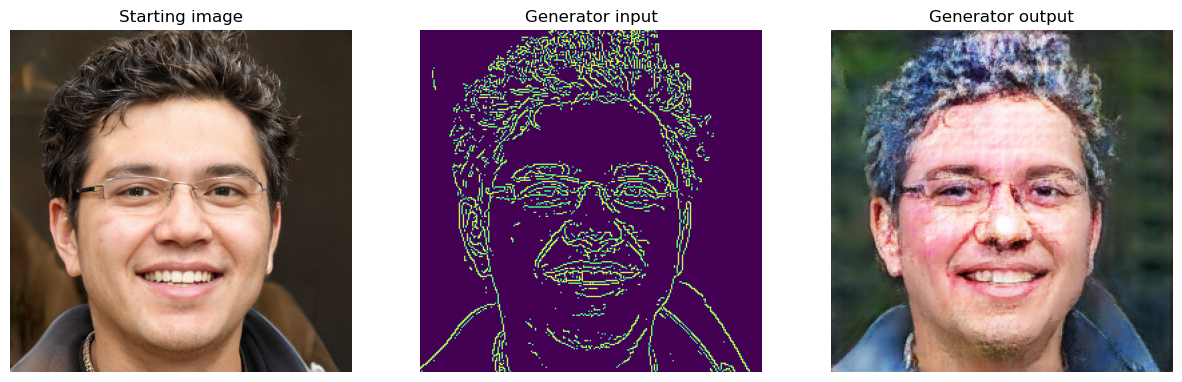

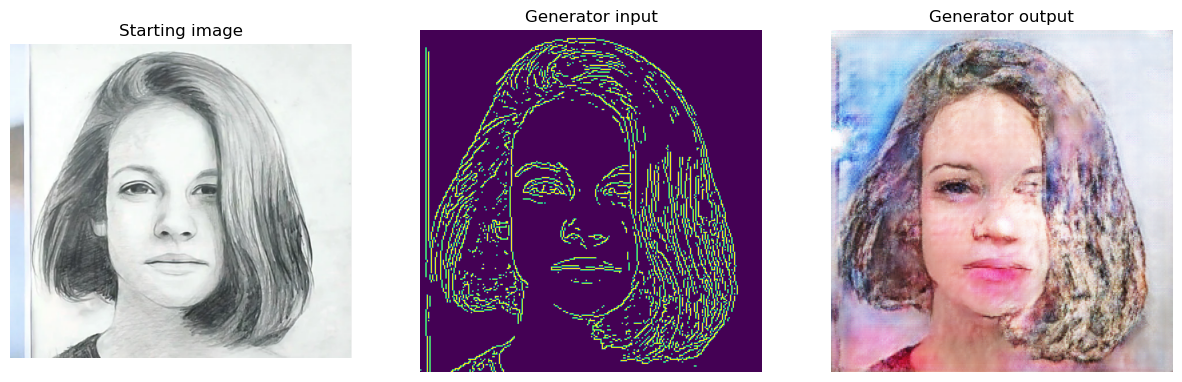

In [80]:
#Trained on human faces
human_face_path = "C:/Users/allan/Downloads/GANFacesDateset/seed0003.png"
generate_edges_reconstructed_image(human_face_path)
#Making a prediction on a non human faces
non_human_face_path = "C:/Users/allan/OneDrive/Desktop/demo_image.jpeg"
generate_edges_reconstructed_image(non_human_face_path)